In [1]:
import guardrails as gd
import openai
from rich import print as rprint
import tiktoken
import dotenv
import os
import pandas as pd

from app.database import Database, db_config

from app.guardrails_specs.specs import rail_str

dotenv.load_dotenv()
OPEN_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPEN_API_KEY


## Loading data

In [2]:
database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)
df.head()

2023-08-17 19:31:22,338 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-08-17 19:31:22,339 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-17 19:31:22,342 INFO sqlalchemy.engine.Engine select current_schema()
2023-08-17 19:31:22,343 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-17 19:31:22,346 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-08-17 19:31:22,346 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-17 19:31:22,347 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-08-17 19:31:22,349 INFO sqlalchemy.engine.Engine SELECT llm_finances.transactions.transaction_id AS llm_finances_transactions_transaction_id, llm_finances.transactions.transaction_date AS llm_finances_transactions_transaction_date, llm_finances.transactions.transaction_description AS llm_finances_transactions_transaction_description, llm_finances.transactions.credit AS llm_finances_transactions_credit, llm_finances.transactions.debit AS llm_finances_transactions_debit, ll

/Users/fernandomeira/projects/LLM-budget-assistant/app/database.py:219: SAWarning: relationship 'User.user_accounts' will copy column users.user_id to column accounts.user_id, which conflicts with relationship(s): 'Account.users' (copies users.user_id to accounts.user_id), 'User.accounts' (copies users.user_id to accounts.user_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="accounts,users"' to the 'User.user_accounts' relationship. (Background on this warning at: https://sqlalche.me/e/20/qzyx) (This warning originated from the `configure_mappers()` process, which was invoked automatically in response to a user-initiated operat

,transaction_id,transaction_date,transaction_description,credit,amount,account_id,category_id,user_id,category
0,237,2023-01-01,"FIVE GUYS BURGERS & FR, 780-436-9885",0.0,46.66,4,17,3,Takeout
1,234,2023-01-02,"SAVE ON FOODS #6622, EDMONTON",0.0,30.31,4,24,3,Grocery
2,236,2023-01-02,"DOLLARAMA #1101, EDMONTON",0.0,46.28,4,30,3,Home Goods
3,235,2023-01-02,"MCDONALD'S #40413, EDMONTON",0.0,8.38,4,17,3,Takeout
4,231,2023-01-06,"PC EXPRESS 1549, EDMONTON",0.0,97.90,4,24,3,Grocery


## Testing cleaning transaction descriptions

**Goal**: Transaction descriptions could be very repetitive. I want to simplify them and make them easy for the users to identify them. At the same time, once the user assigns a category to it, I want to spot all the possible variations of it and use the category already assigned automatically.

#### Testing embeddings

Good examples to try:

- 'Subway 30118, Edmonton'
- 'Subway 39345, Edmonton',
- 'Subway 71142, Edmonton'

_____

- 'SHOP.SHOPPERSDRUGMART., BRAMPTON',
- 'SHOPPERS DRUG MART #03, EDMONTON',
- 'SHOPPERS DRUG MART #24, EDMONTON'

____

- 'PETRO CANADA77958, EDMONTON', 
- 'PETROCAN, EDMONTON',

____

### Trying to use embeddings distances only

In [42]:
# Getting the embeddings for the transaction names

from sentence_transformers import SentenceTransformer
import tiktoken

tnames = df.loc[:, ['transaction_description']].copy().drop_duplicates()

tnames

# Hugging face embeddings
model_name = "BAAI/bge-large-en"
hf_model = SentenceTransformer(model_name)

def get_hf_embeddings(text):
    return hf_model.encode(text)

tnames['hf_embeddings'] = tnames['transaction_description'].apply(get_hf_embeddings)

# OpenAI embeddings

def get_oi_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

tnames['oi_token_count'] = tnames.transaction_description.apply(lambda x: num_tokens_from_string(x, 'cl100k_base'))

print(f"Total cost: {tnames.oi_token_count.sum() * .0001}")
tnames['ada_embedding'] = tnames.transaction_description.apply(lambda x: get_oi_embedding(x, model='text-embedding-ada-002'))

Total cost: 0.0814


In [43]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

tnames.reset_index(drop=True, inplace=True)

def get_most_similar_entry(dataframe: pd.DataFrame, embedding_col:str):
    # Convert embedding_vector to a matrix
    embedding_matrix = np.stack(dataframe[embedding_col].values)

    norms = np.linalg.norm(embedding_matrix, axis=1)

    # Check if all norms are close to 1
    if np.allclose(norms, 1, atol=1e-6):  # you can adjust the tolerance level (atol) as needed
        print(f"The embeddings are normalized. {embedding_col}")
    else:
        print(f"The embeddings are not normalized.{embedding_col}")
        embedding_matrix = normalize(embedding_matrix)

    # Compute the cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(embedding_matrix)

    # Find the most similar transactions for each transaction
    most_similar_indices = np.argmax(cosine_sim_matrix - np.eye(cosine_sim_matrix.shape[0]), axis=1)

    # Add the most similar transaction descriptions to the DataFrame
    return dataframe['transaction_description'].iloc[most_similar_indices].reset_index(drop=True)

tnames['similar_hf'] = get_most_similar_entry(tnames, 'hf_embeddings')
tnames['similar_ada'] = get_most_similar_entry(tnames, 'ada_embedding')

tnames.head(3)

The embeddings are not normalized.hf_embeddings
The embeddings are normalized. ada_embedding


,transaction_description,hf_embeddings,oi_token_count,ada_embedding,similar_hf,similar_ada
0,"#026 MARK'S, EDMONTON","[-0.48328263, 0.13348997, -0.4279842, 0.304612...",8,"[-0.01735464669764042, -0.016036231070756912, ...","T&T SUPERMARKET #024, EDMONTON","REAL CANADIAN SPRST154, EDMONTON"
1,"AMBLESIDE VETERINARY H, EDMONTON","[-0.27046075, 0.17282426, -0.5382303, 0.389169...",11,"[-0.010637522675096989, -0.013460425660014153,...","PETLANDSOUTHPARK, EDMONTON","OH MY DOG SPA AND GROO, EDMONTON"
2,"AMZN Mktp CA*OI0DI4SS3, WWW.AMAZON.CA","[-0.38278243, -0.04545469, -0.40891513, 0.3338...",20,"[-0.00796479918062687, -0.02523753233253956, -...","APPLE.COM/BILL, TORONTO","APPLE.COM/BILL, TORONTO"


In [47]:
tnames.loc[:, ['transaction_description', 'similar_hf', 'similar_ada']].iloc[0:40]

,transaction_description,similar_hf,similar_ada
0,"#026 MARK'S, EDMONTON","T&T SUPERMARKET #024, EDMONTON","REAL CANADIAN SPRST154, EDMONTON"
1,"AMBLESIDE VETERINARY H, EDMONTON","PETLANDSOUTHPARK, EDMONTON","OH MY DOG SPA AND GROO, EDMONTON"
2,"AMZN Mktp CA*OI0DI4SS3, WWW.AMAZON.CA","APPLE.COM/BILL, TORONTO","APPLE.COM/BILL, TORONTO"
3,"APPLE.COM/BILL, 866-712-7753","APPLE.COM/BILL, TORONTO","APPLE.COM/BILL, TORONTO"
4,"APPLE.COM/BILL, TORONTO","APPLE.COM/BILL, 866-712-7753","APPLE.COM/BILL, 866-712-7753"
5,"BAR BURRITO, EDMONTON","TIRAMISU BISTRO, EDMONTON","GOOD BUDDY RESTAURANT, EDMONTON"
6,"BATH & BODY WORKS (CAN, EDMONTON","SQ *CHACHI'S SOUTH COM, Edmonton","IKEA EDMONTON, EDMONTON"
7,"BLOCK 1912, EDMONTON","SQ *EARLS SOUTH COMMON, Edmonton","PETROCAN, EDMONTON"
8,"CDN TIRE STORE #00304, EDMONTON","SAFEWAY #8921, EDMONTON","T&T SUPERMARKET #024, EDMONTON"
9,"CINEPLEX 8030 WEB QPS, 416-323-6600","NETFLIX.COM, 866-716-0414","NETFLIX.COM, 866-716-0414"


### Trying to use embeddings distances only

#### Using Hierarchical Clustering

##### Using TFIDF and common words

In [100]:
samp = tnames.loc[tnames.transaction_description.str.contains('SHOPPERS')]


import re
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def preprocess(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower().strip()

    # Stemming (optional)
    #text = ' '.join([ps.stem(word) for word in text.split()])
    
    return text

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

data = [preprocess(text) for text in tnames.transaction_description]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

# Similarity measurement
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X)

# clustering
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(similarity_matrix, 'ward')
clusters = fcluster(Z, t=1.0, criterion='distance')

tnames['cluster'] = clusters

tnames.loc[tnames.transaction_description.str.contains('SHOPPERS')]

# Silhouette score
from sklearn.metrics import silhouette_score

score = silhouette_score(similarity_matrix, clusters)
print('Silhouette Score:', score)


Silhouette Score: 0.14331568000727804


In [101]:
from collections import Counter

group_names = {}
for cluster_id in set(clusters):
    # Extract transactions in the cluster
    cluster_transactions = [data[i] for i in range(len(data)) if clusters[i] == cluster_id]
    
    # Find common prefix or use other logic to determine the group name
    common_prefix = re.findall(r'^\w+', cluster_transactions[0])
    if common_prefix:
        group_name = common_prefix[0]
    else:
        # Alternatively, find the most common word in the cluster
        words = ' '.join(cluster_transactions).split()
        common_word, _ = Counter(words).most_common(1)[0]
        group_name = common_word
    
    group_names[cluster_id] = group_name

In [67]:
tnames.sort_values('cluster').head(50)

,transaction_description,cluster
36,"Subway 39345, Edmonton",1
78,"Subway 71142, Edmonton",1
83,"Subway 30118, Edmonton",1
152,"APPLE.COM/BILL, 866-712-7753",2
48,"APPLE.COM/BILL, TORONTO",2
203,"PETRO CANADA77958, EDMONTON",3
188,"TICKETMASTER CANADA, TORONTO",4
120,"MSF CAN DONATION, TORONTO",5
53,"UBER CANADA/UBEREATS, TORONTO",6
147,"GUM.CO/CC* DANIEL VASS, SAN FRANCISCO, CA Fore...",7


##### Using embeddings with cosine similarity

In [97]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster

tnames = df.loc[:, ['transaction_description']].copy().sort_values('transaction_description').drop_duplicates()

# Hugging face embeddings
model_name = "BAAI/bge-large-en"
hf_model = SentenceTransformer(model_name)

def get_hf_embeddings(text):
    return hf_model.encode(text)

tnames['hf_embeddings'] = tnames['transaction_description'].apply(get_hf_embeddings)

# getting the similarity matrix
similarity_matrix = cosine_similarity(np.stack(tnames['hf_embeddings']))

Z = linkage(similarity_matrix, 'ward')
clusters = fcluster(Z, t=1.0, criterion='distance')

tnames['cluster'] = clusters


In [92]:
tnames.sort_values('cluster').head(50)

,transaction_description,hf_embeddings,cluster
55,"#026 MARK'S, EDMONTON","[-0.48328263, 0.13348997, -0.4279842, 0.304612...",1
3,"MCDONALD'S #40413, EDMONTON","[-0.46324992, 0.28452635, -0.51678395, 0.52149...",1
17,"STARBUCKS 04943, EDMONTON","[-0.26897845, 0.4319626, -0.22301814, 0.345766...",1
57,"STAPLES STORE #150, EDMONTON","[-0.3693039, 0.23304509, -0.12379238, 0.535995...",1
207,"SQ *PADMANADI VEGAN EA, Edmonton","[-0.54667926, 0.381867, -0.81127596, 0.3976022...",1
41,"OH MY DOG SPA AND GROO, EDMONTON","[0.046913486, 0.36986396, -0.5216679, 0.130762...",1
217,"SQ *LOCAL SOUTH COMMON, Edmonton","[0.059590332, 0.74862564, -0.4226278, 0.444408...",1
121,"PARAISO TROPICAL, EDMONTON","[-0.2952851, 0.70257336, -0.47817856, -0.10525...",1
34,"SQ *EARLS SOUTH COMMON, Edmonton","[-0.12224142, 0.58090115, -0.34334987, 0.16611...",1
129,"SQ *CHACHI'S SOUTH COM, Edmonton","[-0.24869522, 0.788576, -0.49792945, 0.6446774...",1


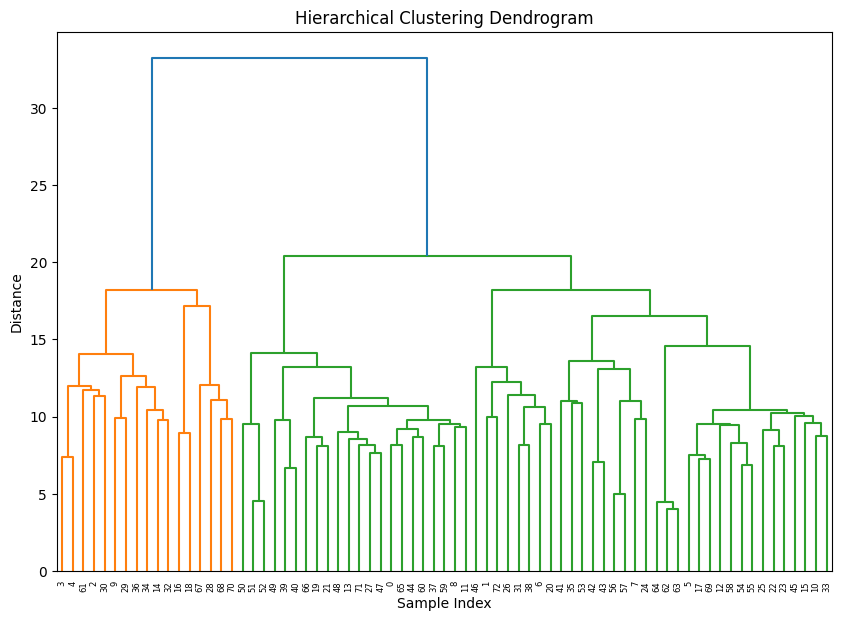

In [98]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt




# Assuming you have a DataFrame 'df' with 'text' and 'embeddings' columns
# For example:
# df = pd.DataFrame({'text': ['Sentence 1', 'Sentence 2', ...], 'embeddings': [embedding1, embedding2, ...]})

# Step 1: Extracting the embeddings
embeddings = tnames['hf_embeddings'].tolist()

# Step 2: Hierarchical clustering
linked = linkage(embeddings, method='ward')

# Step 3: Plotting the dendrogram to determine the number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Cut the tree at a specific height to get the clusters (e.g., 50)
clusters = fcluster(linked, 50, criterion='distance')

# Step 4: Assigning clusters back to the DataFrame
tnames['cluster'] = clusters


In [99]:
tnames.sort_values('cluster').head(50)

,transaction_description,hf_embeddings,cluster
55,"#026 MARK'S, EDMONTON","[-0.48328263, 0.13348997, -0.4279842, 0.304612...",1
69,"SHOPPERS DRUG MART #03, EDMONTON","[-0.40419304, 0.1221714, -0.29019156, 0.751205...",1
134,"SHOP.SHOPPERSDRUGMART., BRAMPTON","[-0.7454593, -0.114540145, -0.50675946, 0.7448...",1
220,"SHELL C44095, EDMONTON","[-0.62037176, 0.46749473, -0.11908287, 0.28934...",1
67,"SAVE ON FOODS #6622, EDMONTON","[-0.43682563, 0.26770377, -0.46417317, 0.58928...",1
110,"SAFEWAY #8921, EDMONTON","[-0.453289, 0.7269577, -0.5779839, 0.79151034,...",1
45,"RIVERVIEW CHIROPRACTIC, ST. ALBERT","[-0.42030445, 0.45808253, -0.6222953, 0.466410...",1
91,"SHOPPERS DRUG MART #24, EDMONTON","[-0.50778097, -0.046164073, -0.5397479, 0.9163...",1
210,"REMEDY CAFE - TERWILLE, EDMONTON","[-0.3549445, 0.19859679, -0.6815988, 0.3661802...",1
144,"Presotea, Edmonton","[-0.46627122, 0.1716002, -0.4432886, 0.1516264...",1
